<table>
<tr>    
<td style="text-align: center">
<h1>Wprowadzenie do optymalizacji, regularyzacji, generalizacji<br />oraz radzenie sobie z niedopasowaniem i nadmiernym<br /> dopasowaniem modeli sieci neuronowych</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index.php">Adrian Horzyk</a></h2>
</td> 
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk49BT140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
</tr>
</table>
<h3><i>Zapraszam do interaktywnego notebooka, w którym możesz dowiedzieć się, jak działają sieci neuronowe, doświadczysz i sprawdzisz ich działanie na wybranych zbiorach danych i przeprowadzisz własne eksperymenty!</i></h3>

# Optymalizacja modeli sieci neuronowych

Optymalizacja opracowanych modeli jest normalnym procesem dla każdego problemu, który chcemy rozwiązać za pomocą metod inteligencji obliczeniowej. Większość metod i algorytmów wymaga udziału programisty w tworzeniu ostatecznego modelu. Proces ten obejmuje wykorzystanie różnych metod optymalizacji i regularyzacji, przygotowanie, generowanie i rozszerzanie danych (augmentacja), eksperymenty z różnymi strukturami sieci oraz ustawienie odpowiednich hiperparametrów.

# Problemy z niedopasowaniem i nadmiernym dopasowaniem modeli

Jak doświadczyliśmy w poprzednich przykładach (przewidywanie nastrojów w recenzjach filmów, klasyfikacja tematów i regresja cen domów), mogliśmy zauważyć, że wydajność naszych modeli na danych walidacyjnych zawsze osiągała szczyt po kilku epokach, a następnie zaczynała się pogarszać, tj. model szybko zaczął się <b>nadmiernie dopasowywać</b> (wzrosła <b>wariancja (variance)</b> modelu). Czasami mieliśmy też problemy z osiągnięciem wystarczająco dobrych wyników treningowych (<b>błąd (bias)</b> modelu), lecz nie osiągnęliśmy wystarczająco dużej dokładności lub wystarczająco małej straty, co nazywamy problemem <b>niedopasowania</b> modelu.

Niedopasowanie i nadmierne dopasowanie może wystąpić w przypadku każdego problemu związanego z uczeniem maszynowym. Nauka radzenia sobie z niedopasowaniem i nadmiernym dopasowaniem jest niezbędna do opanowania uczenia maszynowego i inteligencji obliczeniowej.

Podstawową kwestią w uczeniu maszynowym jest napięcie między optymalizacją a generalizacją:
* <b>Optymalizacja</b> odnosi się do procesu dostosowywania modelu w celu uzyskania jak najlepszej wydajności danych treningowych (niskie <b>bias</b> uczenia się).
* <b>Uogólnienie</b> odnosi się do tego, jak dobrze wyszkolony model poradziłby sobie z (testowymi i nowymi) danymi, których nigdy wcześniej nie widział (niska <b>variance</b> uczenia się).

Celem jest uzyskanie zarówno dobrego dopasowania modelu do danych uczących, jak i dobrej generalizacji.

Na początku treningu optymalizacja i generalizacja są skorelowane: im mniejsza utrata danych treningowych, tym mniejsza utrata danych testowych. Gdy tak się dzieje, mówi się, że Twój model jest <b>niedopasowany</b>, co oznacza, że wciąż trzeba zrobić postęp, ponieważ sieć nie wymodelowała jeszcze wszystkich istotnych wzorców w danych treningowych. Ale po pewnej liczbie iteracji danych treningowych generalizacja przestaje się poprawiać, metryki walidacji zatrzymują się, a następnie zaczynają się degradować: model zaczyna <b>nadmiernie się dopasowywać</b>, tj. zaczyna uczyć się specyficznych i nieistotnych cech danych uczących, które prowadzą do uczenia się na pamięć danych uczących, co prowadzi do słabej wydajności modelu na nowych (testowych) danych, wtedy mówimy, że model uczy się na pamięć, a jakość generalizacji pogarsza się.

Aby uniemożliwić modelowi nauczenie się wprowadzających w błąd lub nieistotnych wzorców znalezionych w danych uczących, możemy wykonać kilka czynności:
* trenuj model, używając większej ilości danych treningowych dokonaj ich poszerzenia (augmentację), ponieważ wtedy model będzie naturalnie lepiej generalizował;
* dostosuj ilość informacji, które twój model może przechowywać, lub dodaj ograniczenia dotyczące tego, jakie informacje mogą przechowywać, ponieważ jeśli sieć może sobie pozwolić na zapamiętanie tylko niewielkiej liczby wzorców, proces optymalizacji zmusi ją do skupienia się na najistotniejsze wzorce, które mają większe szanse na dobre uogólnienie;
* użyj innych metod regularyzacji, takich jak porzucanie (dropout).

Walka z nadmiernym dopasowaniem nazywa się <b>regularyzacją</b>. Przyjrzyjmy się niektórym najpopularniejszym technikom regularyzacji i zastosujmy je w praktyce, aby ulepszyć nasz model klasyfikacji filmów.

In [1]:
import numpy as np
import tensorflow as tf
import keras

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

2024-04-09 15:07:18.412068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.1
Keras version: 3.0.5


## Walka z nadmiernym dopasowaniem: zmiana liczby najczęściej używanych słów

Sprawdźmy, jak liczba najczęściej używanych słów (`num_top_words`) wpływa na proces uczenia na tym samym rozmiarze zbioru danych:

In [2]:
from keras.datasets import imdb

def vectorize_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # set specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results

def vectorize_data_float_labels(data, labels, dimension):
    # Our vectorized training data
    x = vectorize_sequences(data, dimension)
    # Our vectorized labels
    y = np.asarray(labels).astype('float32')
    return x, y

In [3]:
def Create3LModel(num_top_words, hl1 = 16, hl2 = 8):
    model = models.Sequential()
    model.add(layers.Dense(hl1, activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [4]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=5000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model5000 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model5000.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

history5000 = model5000.fit(x_train, y_train,
                            epochs=50,
                            batch_size=256,
                            validation_data=(x_val, y_val))

/Users/maciekadamus/opt/anaconda3/envs/ggsn/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - acc: 0.7503 - loss: 0.5302 - val_acc: 0.8818 - val_loss: 0.3086
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - acc: 0.9008 - loss: 0.2654 - val_acc: 0.8860 - val_loss: 0.2805
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9198 - loss: 0.2162 - val_acc: 0.8771 - val_loss: 0.3035
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9275 - loss: 0.1960 - val_acc: 0.8816 - val_loss: 0.2961
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9318 - loss: 0.1845 - val_acc: 0.8789 - val_loss: 0.3106
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9370 - loss: 0.1702 - val_acc: 0.8732 - val_loss: 0.3357
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9398 - loss: 0.1618 - val_acc: 0.8685 - val_loss: 0.3575
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9428 - loss: 0.1539 - val_acc: 0.8593 - val_loss: 0.3970
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.945

In [5]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model10000 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model10000.compile(optimizer='rmsprop',
                   loss='binary_crossentropy',
                   metrics=['acc'])

history10000 = model10000.fit(x_train, y_train,
                              epochs=50,
                              batch_size=256,
                              validation_data=(x_val, y_val))

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - acc: 0.7830 - loss: 0.4883 - val_acc: 0.8686 - val_loss: 0.3238
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.9184 - loss: 0.2296 - val_acc: 0.8859 - val_loss: 0.2815
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.9379 - loss: 0.1772 - val_acc: 0.8843 - val_loss: 0.2946
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.9503 - loss: 0.1475 - val_acc: 0.8780 - val_loss: 0.3185
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - acc: 0.9580 - loss: 0.1256 - val_acc: 0.8747 - val_loss: 0.3421
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.9614 - loss: 0.1146 - val_acc: 0.8703 - val_loss: 0.3766
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.9693 - loss: 0.0964 - val_acc: 0.8689 - val_loss: 0.3930
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.9728 - loss: 0.0837 - val_acc: 0.8637 - val_loss: 0.4381
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - acc: 0.97

In [6]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2000 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model2000.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

history2000 = model2000.fit(x_train, y_train,
                            epochs=50,
                            batch_size=256,
                            validation_data=(x_val, y_val))

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - acc: 0.7366 - loss: 0.5267 - val_acc: 0.8720 - val_loss: 0.3174
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - acc: 0.8795 - loss: 0.2965 - val_acc: 0.8771 - val_loss: 0.2971
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8977 - loss: 0.2602 - val_acc: 0.8744 - val_loss: 0.3013
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9009 - loss: 0.2471 - val_acc: 0.8709 - val_loss: 0.3101
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9006 - loss: 0.2452 - val_acc: 0.8668 - val_loss: 0.3206
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9015 - loss: 0.2430 - val_acc: 0.8662 - val_loss: 0.3276
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9067 - loss: 0.2368 - val_acc: 0.8666 - val_loss: 0.3186
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9071 - loss: 0.2308 - val_acc: 0.8686 - val_loss: 0.3202
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9108 - loss:

In [7]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html
    
def PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, lab1 = '1', lab2 = '2', lab3 = '3'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    epochs = range(1, len(acc1) + 1)
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.plot(epochs, acc3, 'go', label='Training accuracy for ' + lab3)
    plt.plot(epochs, val_acc3, 'g', label='Validation accuracy for ' + lab3)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

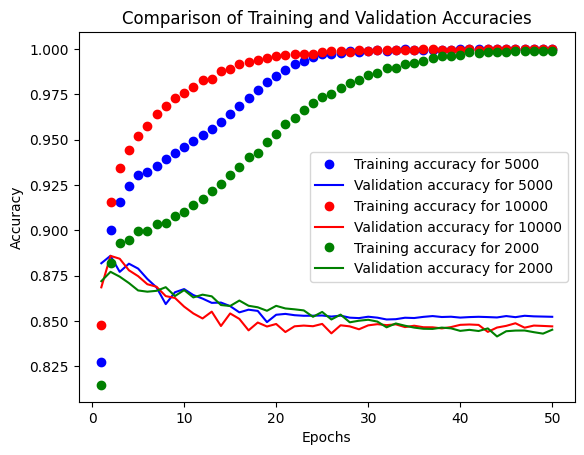

In [8]:
# Compare the accuracies of three training processes
acc5000 = history5000.history['acc']
val_acc5000 = history5000.history['val_acc']
acc10000 = history10000.history['acc']
val_acc10000 = history10000.history['val_acc']
acc2000 = history2000.history['acc']
val_acc2000 = history2000.history['val_acc']

PlotThreeAccuracyComparison(acc5000, val_acc5000, acc10000, val_acc10000, acc2000, val_acc2000, '5000', '10000', '2000')

In [9]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

def PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, lab1 = '1', lab2 = '2', lab3 = '3'):
    plt.clf()   # clear figure
    plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.plot(epochs, loss3, 'go', label='Training loss for ' + lab3)
    plt.plot(epochs, val_loss3, 'g', label='Validation loss for ' + lab3)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

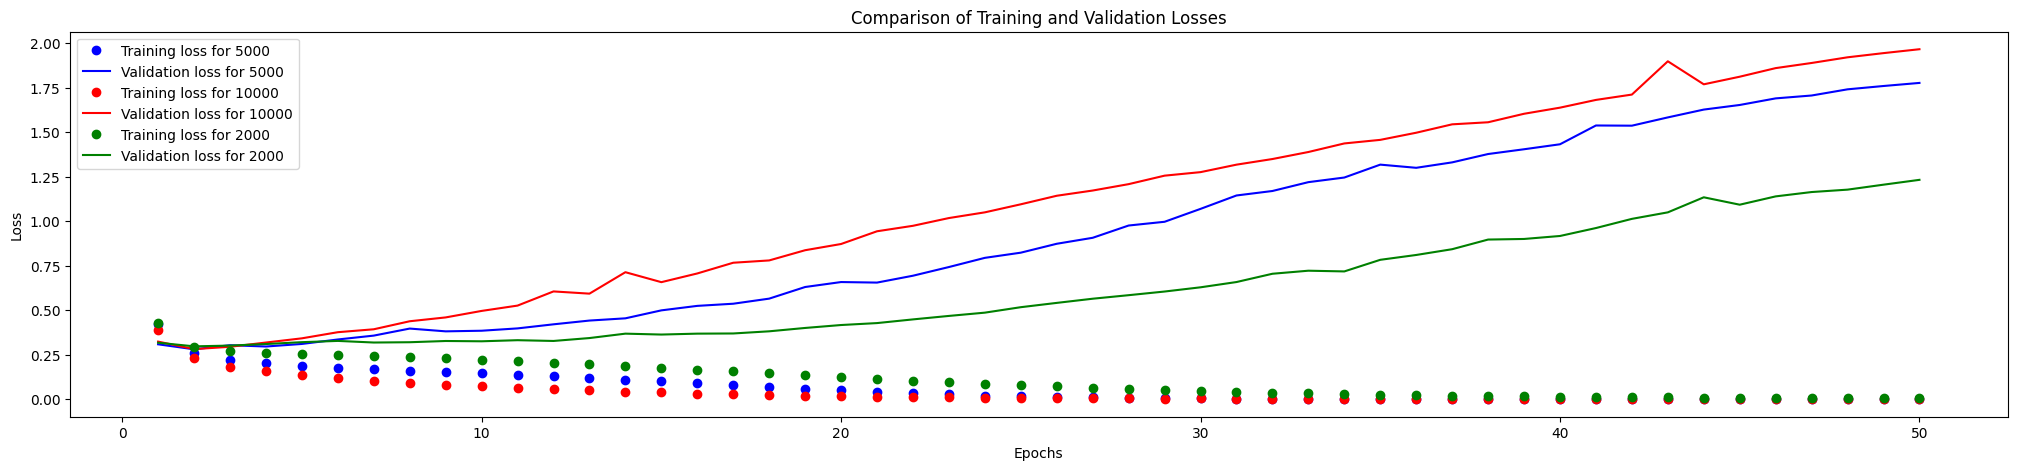

In [10]:
# Compare the losses of three training processes
loss5000 = history5000.history['loss']
val_loss5000 = history5000.history['val_loss']
loss10000 = history10000.history['loss']
val_loss10000 = history10000.history['val_loss']
loss2000 = history2000.history['loss']
val_loss2000 = history2000.history['val_loss']

PlotThreeLossComparison(loss5000, val_loss5000, loss10000, val_loss10000, loss2000, val_loss2000, '5000', '10000', '2000')

In [11]:
argmax1 = np.argmax(val_acc5000)
argmax2 = np.argmax(val_acc10000)
argmax3 = np.argmax(val_acc2000)
print ('Max accuracy for model 1 is: ', val_acc5000[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc10000[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc2000[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8859599828720093 , achieved in the  1 epoch.
Max accuracy for model 2 is:  0.885919988155365 , achieved in the  1 epoch.
Max accuracy for model 3 is:  0.8771200180053711 , achieved in the  1 epoch.


Pokazuje maksymalne dokładności walidacji osiągnięte podczas szkolenia oraz epokę, w której to nastąpiło.

## Uwagi

Jak widać, dokładność modelu rośnie wolniej dla mniejszej liczby używanych słów, ale utrata walidacji maleje wraz ze zmniejszaniem się liczby najczęściej używanych słów. Możemy więc stwierdzić, że użycie mniejszej liczby najczęściej używanych słów jest skuteczne w tym zadaniu.

Możemy również zauważyć, że proces adaptacji najmniejszego zestawu najczęściej występujących słów zajmuje najwięcej czasu (co widać na wykresie "Accuracy"), ale jest to pozytywna konsekwencja wymuszenia na sieci uczenia się skompresowanej reprezentacji, co skutkuje lepszą generalizacją niż w przypadku modeli, które dopasowują się zbyt szybko! Możemy stwierdzić, że jeśli model dopasowuje się bardzo/zbyt szybko, to najprawdopodobniej będzie się nadmiernie dopasowywał!

Teraz możesz spróbować sprawdzić inne numery najczęściej występujących słów, np. num_top_words=1500 lub 1000 lub 500 i znajdź optymalną liczbę takich słów użytych do budowy tego modelu.

## Walka z nadmiernym dopasowaniem: Zmniejszanie rozmiaru sieci

Jednym z najprostszych sposobów zapobiegania nadmiernemu dopasowaniu jest zmniejszenie rozmiaru modelu, czyli liczby możliwych do nauczenia parametrów (np. W uczeniu głębokim liczba możliwych do nauczenia parametrów w modelu jest często określana jako <b>„pojemność” modelu</b>. Intuicyjnie, model z większą liczbą parametrów będzie miał większą „zdolność do zapamiętywania”, a zatem będzie w stanie łatwo nauczyć się doskonałego słownikowego mapowania między próbkami treningowymi a ich celami/etykietami na zbiorze uczącym, tj. <b>mapowania bez umiejętności uogólnienia</b> - tego nie chcemy!

Na przykład model z 600 000 parametrów binarnych można łatwo stworzyć tak, aby nauczył się klas wszystkich cyfr
Zestaw treningowy MNIST: potrzebowalibyśmy tylko 10 parametrów binarnych dla każdej z 60 000 cyfr. Jednak taki model byłby bezużyteczny do klasyfikowania próbek nowych cyfr. Nie wierzysz, sprawdź! Pamiętaj o tym: modele głębokiego uczenia się zwykle dobrze dopasowują się do danych treningowych, ale prawdziwym wyzwaniem jest uogólnienie, a nie dopasowanie. Kiedy generalizacja jest słaba, model jest bezużyteczny!

Z drugiej strony, jeśli sieć ma ograniczone zasoby zapamiętywania, nie będzie w stanie łatwo nauczyć się pożądanego odwzorowania, a zatem, aby zminimalizować jego stratę (loss), będzie musiała uciekać się do uczenia się skompresowanych reprezentacji, które mają moc predykcyjną w odniesieniu do celu nauki — dokładnie taki typ reprezentacji, jaki nas interesuje! Jednocześnie pamiętaj, że powinieneś używać modeli, które mają wystarczająco dużo parametrów, aby nie były niedopasowane: Twój model nie powinien być ani zagłodzony ani przesycony - czyli szukamy optymalnej liczby zasobów do zapamiętywania. Dlatego musimy znaleźć odpowiedni kompromis między „zbyt dużą pojemnością” a „niewystarczającą pojemnością” (liczbą parametrów modelu) modelu.

Niestety, nie ma magicznej formuły, która pozwoliłaby określić, jaka jest właściwa liczba warstw lub jaki jest odpowiedni rozmiar każdej warstwy. To dobry temat do badań naukowych! Będziesz musiał ocenić szereg różnych architektur (w swoim zestawie walidacyjnym), aby znaleźć odpowiedni rozmiar modelu dla swoich danych. Ogólny plan pracy, mający na celu znalezienie odpowiedniego rozmiaru modelu, polega na rozpoczęciu od stosunkowo niewielkiej liczby warstw i rozmiarów warstw i jego stopniowe zwiększanie, jeśli zmiany przynoszą pozytywne efekty uczenia mierzone przez różne miary błędów i dokładności.

Spróbujmy to zrobić w naszej sieci klasyfikacji recenzji filmów. Porównamy trzy sieci o różnej liczbie jednostek w warstwach ukrytych, używając 2000 najczęściej występujących słów, ponieważ stwierdzono, że zwracają one najniższe straty (loss):

In [12]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModel(num_top_words=num_top_words, hl1 = 16, hl2 = 8)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history1 = model1.fit(x_train, y_train,
                      epochs=100,
                      batch_size=256,
                      validation_data=(x_val, y_val))

/Users/maciekadamus/opt/anaconda3/envs/ggsn/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - acc: 0.7275 - loss: 0.5445 - val_acc: 0.8696 - val_loss: 0.3304
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8785 - loss: 0.3037 - val_acc: 0.8670 - val_loss: 0.3189
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8931 - loss: 0.2662 - val_acc: 0.8760 - val_loss: 0.2986
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8955 - loss: 0.2575 - val_acc: 0.8754 - val_loss: 0.3017
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8992 - loss: 0.2526 - val_acc: 0.8727 - val_loss: 0.3085
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9059 - loss: 0.2382 - val_acc: 0.8676 - val_loss: 0.3209
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9076 - loss: 0.2351 - val_acc: 0.8689 - val_loss: 0.3168
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9117 - loss: 0.2258 - val_acc: 0.8668 - val_loss: 0.3234
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.911

In [13]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModel(num_top_words=num_top_words, hl1 = 64, hl2 = 32)

model2.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

history2 = model2.fit(x_train, y_train,
                      epochs=100,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - acc: 0.7413 - loss: 0.5130 - val_acc: 0.8516 - val_loss: 0.3459
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.8865 - loss: 0.2832 - val_acc: 0.8743 - val_loss: 0.2992
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.8968 - loss: 0.2555 - val_acc: 0.8731 - val_loss: 0.3068
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - acc: 0.9056 - loss: 0.2379 - val_acc: 0.8712 - val_loss: 0.3069
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9150 - loss: 0.2137 - val_acc: 0.8722 - val_loss: 0.3069
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9307 - loss: 0.1852 - val_acc: 0.8676 - val_loss: 0.3188
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9407 - loss: 0.1569 - val_acc: 0.8676 - val_loss: 0.3249
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9601 - loss: 0.1254 - val_acc: 0.8657 - val_loss: 0.3480
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ac

In [14]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModel(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history3 = model3.fit(x_train, y_train,
                      epochs=100,
                      batch_size=256,
                      validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - acc: 0.7126 - loss: 0.6049 - val_acc: 0.8534 - val_loss: 0.4084
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8712 - loss: 0.3609 - val_acc: 0.8719 - val_loss: 0.3193
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8885 - loss: 0.2884 - val_acc: 0.8754 - val_loss: 0.3017
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8951 - loss: 0.2669 - val_acc: 0.8754 - val_loss: 0.2982
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9022 - loss: 0.2496 - val_acc: 0.8744 - val_loss: 0.2984
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9035 - loss: 0.2435 - val_acc: 0.8723 - val_loss: 0.3036
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9102 - loss: 0.2325 - val_acc: 0.8705 - val_loss: 0.3127
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.9101 - loss: 0.2323 - val_acc: 0.8695 - val_loss: 0.3171
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.90

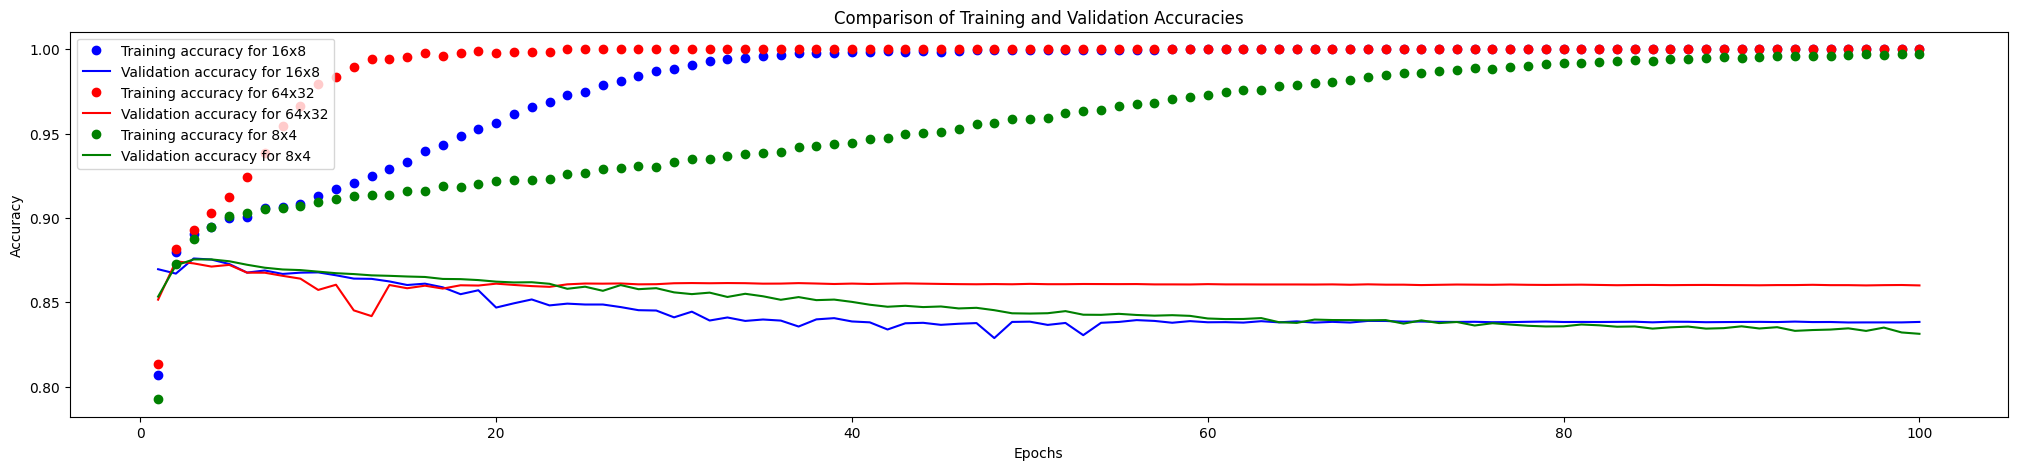

In [15]:
# Compare the accuracies of three training processes
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, '16x8', '64x32', '8x4')

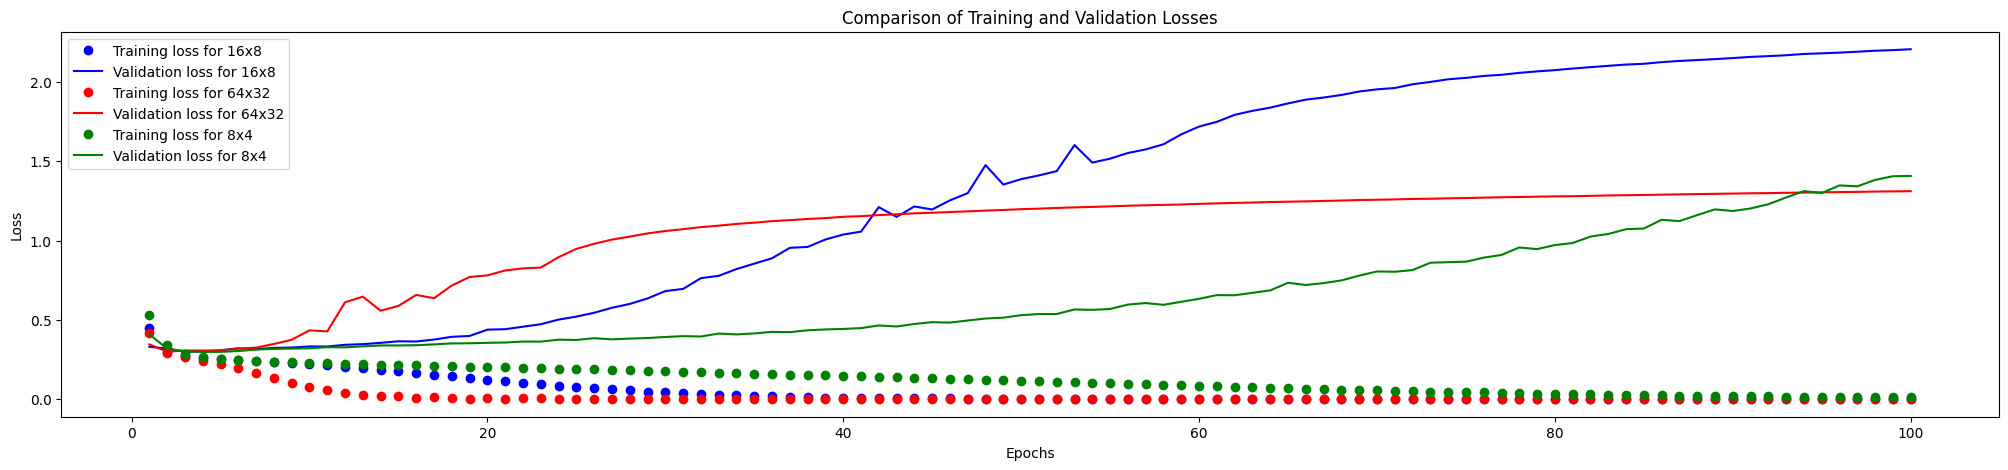

In [16]:
# Compare the losses of three training processes
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, '16x8', '64x32', '8x4')

Ponownie model z najmniejszą liczbą jednostek w warstwach ukrytych osiągnął najmniejszą stratę w porównaniu z pozostałymi dwoma modelami; jednak uczył się najwolniej, ponieważ reprezentacja w małej liczbie jednostek jest trudniejsza niż w przypadku innych sieci. Jak widzieliśmy, powinniśmy trenować ten model nawet dłużej niż przez 100 epok.

Największy model uzyskał zbieżność bardzo szybko i idealnie pasował do prawie wszystkich przykładów uczących, ale jego właściwości uogólniające są najgorsze z porównywanych modeli, ponieważ ma zbyt dużą pojemność zapamiętywania.

In [17]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8759999871253967 , achieved in the  2 epoch.
Max accuracy for model 2 is:  0.8743199706077576 , achieved in the  1 epoch.
Max accuracy for model 3 is:  0.8754400014877319 , achieved in the  2 epoch.


Pokazuje maksymalne dokładności walidacji osiągnięte podczas nauki oraz epokę, w której to nastąpiło.

## Walka z nadmiernym dopasowaniem: Dodawanie regularyzacji wagi

Jeśli mamy dwa wyjaśnienia czegoś, to kierując się zasadą brzytwy Ockhama, wyjaśnienie, które najprawdopodobniej będzie poprawne, to wyjaśnienie „najprostsze”, tj. takie, które zawiera najmniej założeń. Dotyczy to również modeli neuronowych: prostsze modele są mniej podatne na nadmierne dopasowanie niż modele złożone.

„Prosty model” to model, w którym rozkład wartości parametrów ma mniejszą entropię. Dlatego powszechnym sposobem łagodzenia nadmiernego dopasowania jest nałożenie ograniczeń na złożoność sieci poprzez wymuszenie, aby jej wagi przyjmowały tylko małe wartości, co sprawia, że rozkład wartości wag jest bardziej „regularny”. Nazywa się to <b>regularyzacją wag</b> i odbywa się poprzez dodanie do funkcji strat sieci _cost_ związanego z posiadaniem dużych wag. Ten _cost_ występuje w dwóch wariantach:
* <b>regularyzacja L1</b>, gdzie dodany _cost_ jest proporcjonalny do _absolute value of the weights coefficients_ (nazywanej „<b>normą L1</b>” wag).
* <b>Regularyzacja L2</b>, gdzie dodany _cost_ jest proporcjonalny do _square of the value of the weights coefficients_ (nazywanych „<b>normą L2</b>” wag). Regularyzacja L2 jest również nazywana <b>_rozpadem wagi (weight decay)_</b> w kontekście sieci neuronowych. Nie daj się zmylić innej nazwie: rozkład masy jest matematycznie dokładnie taki sam jak regularyzacja L2.

W Keras regularyzacja wagi jest dodawana poprzez przekazanie _weight regularizer instances_ do warstw jako argumentów słów kluczowych. Do wyboru mamy trzy opcje:

In [18]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L2 regularization
regularizers.l2(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

Dodajmy regularyzację wagi do naszej najlepszej sieci klasyfikacji recenzji filmów znalezionej w poprzednich krokach i sprawdźmy wszystkie trzy opcje:

In [19]:
def Create3LModelL1(num_top_words, hl1 = 8, hl2 = 4):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def Create3LModelL2(num_top_words, hl1 = 8, hl2 = 4):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l2(0.001),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

def Create3LModelL1L2(num_top_words, hl1 = 8, hl2 = 4):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [20]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModelL1(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyL1 = model1.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - acc: 0.6840 - loss: 0.8636 - val_acc: 0.8273 - val_loss: 0.5718
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8437 - loss: 0.5386 - val_acc: 0.8497 - val_loss: 0.4947
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8544 - loss: 0.4787 - val_acc: 0.8548 - val_loss: 0.4658
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8605 - loss: 0.4538 - val_acc: 0.8608 - val_loss: 0.4438
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8703 - loss: 0.4284 - val_acc: 0.8636 - val_loss: 0.4334
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8701 - loss: 0.4196 - val_acc: 0.8661 - val_loss: 0.4250
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8765 - loss: 0.4068 - val_acc: 0.8670 - val_loss: 0.4213
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8781 - loss: 0.3951 - val_acc: 0.8641 - val_loss: 0.4202
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8

In [21]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModelL2(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyL2 = model2.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - acc: 0.7370 - loss: 0.5546 - val_acc: 0.8663 - val_loss: 0.3642
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8739 - loss: 0.3401 - val_acc: 0.8642 - val_loss: 0.3488
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8944 - loss: 0.2917 - val_acc: 0.8734 - val_loss: 0.3310
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8940 - loss: 0.2897 - val_acc: 0.8712 - val_loss: 0.3363
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9030 - loss: 0.2744 - val_acc: 0.8732 - val_loss: 0.3307
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - acc: 0.9028 - loss: 0.2767 - val_acc: 0.8722 - val_loss: 0.3325
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8996 - loss: 0.2772 - val_acc: 0.8712 - val_loss: 0.3350
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9051 - loss: 0.2704 - val_acc: 0.8701 - val_loss: 0.3395
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.90

In [22]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModelL1L2(num_top_words=num_top_words, hl1 = 8, hl2 = 4)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyL3 = model3.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - acc: 0.7213 - loss: 0.8560 - val_acc: 0.8436 - val_loss: 0.5448
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8577 - loss: 0.5157 - val_acc: 0.8601 - val_loss: 0.4811
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8592 - loss: 0.4732 - val_acc: 0.8611 - val_loss: 0.4611
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8674 - loss: 0.4491 - val_acc: 0.8644 - val_loss: 0.4498
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8675 - loss: 0.4417 - val_acc: 0.8662 - val_loss: 0.4398
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8770 - loss: 0.4225 - val_acc: 0.8693 - val_loss: 0.4308
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8730 - loss: 0.4240 - val_acc: 0.8699 - val_loss: 0.4272
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8819 - loss: 0.4072 - val_acc: 0.8573 - val_loss: 0.4437
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.879

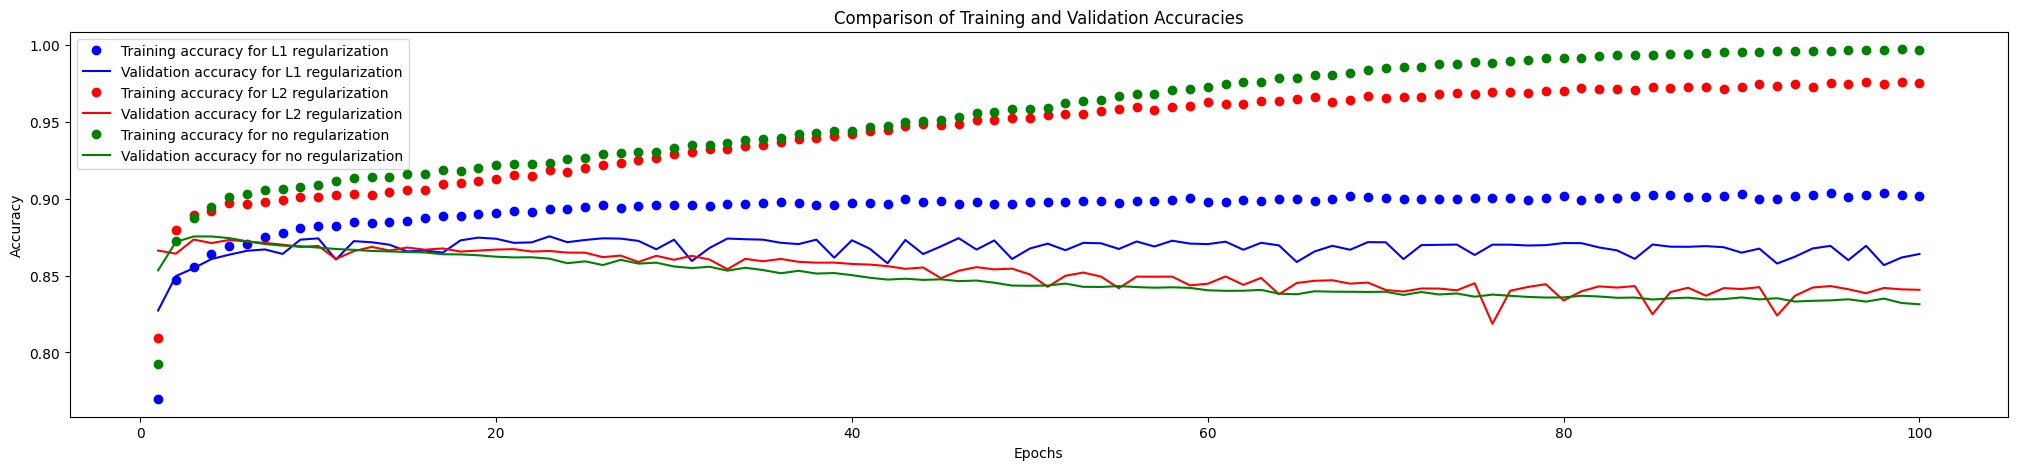

In [23]:
# Compare the accuracies of three training processes
acc1 = historyL1.history['acc']
val_acc1 = historyL1.history['val_acc']
acc2 = historyL2.history['acc']
val_acc2 = historyL2.history['val_acc']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, 'L1 regularization', 'L2 regularization', 'no regularization')

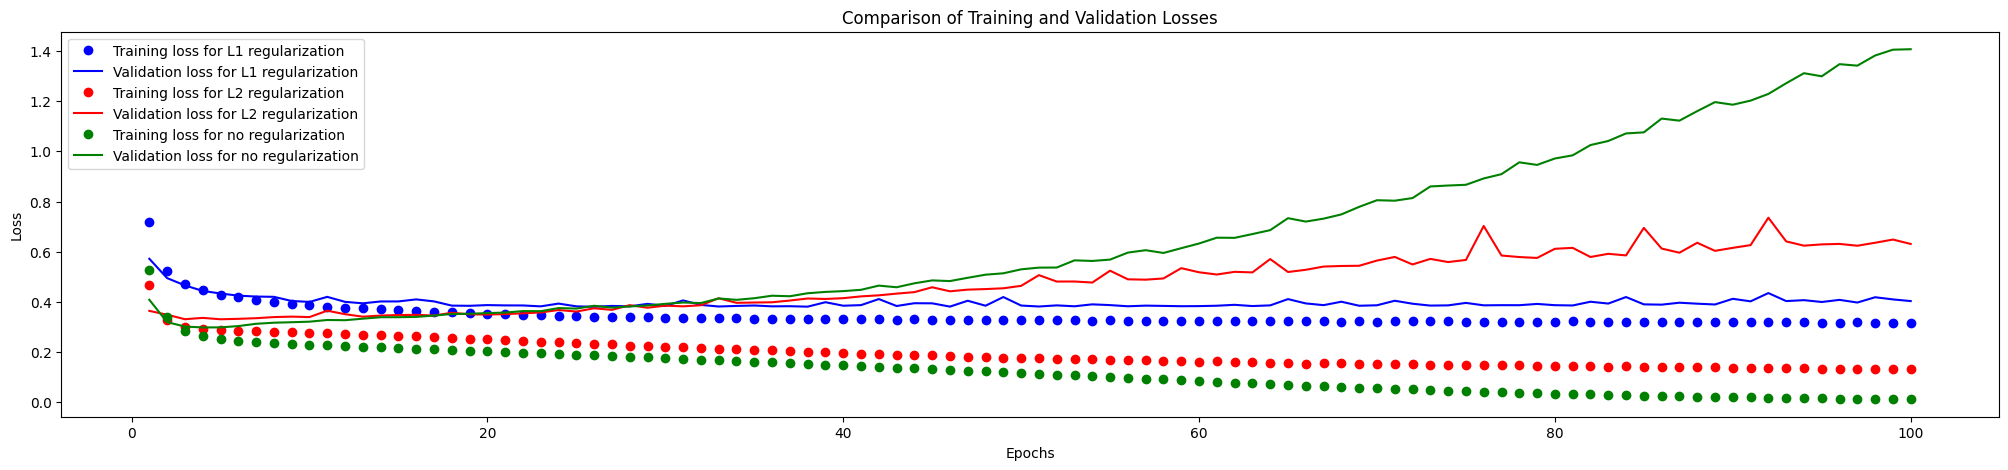

In [24]:
# Compare the losses of three training processes
loss1 = historyL1.history['loss']
val_loss1 = historyL1.history['val_loss']
loss2 = historyL2.history['loss']
val_loss2 = historyL2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, 'L1 regularization', 'L2 regularization', 'no regularization')

In [25]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8755199909210205 , achieved in the  22 epoch.
Max accuracy for model 2 is:  0.8734400272369385 , achieved in the  2 epoch.
Max accuracy for model 3 is:  0.8754400014877319 , achieved in the  2 epoch.


Teraz możemy porównać wyniki uczenia dla modelu bez regularyzacji oraz modeli z regularyzacją L1 lub L2.

Model bez regularyzacji miał mniejsze straty w czasie uczenia, ale dla danych walidacyjnych widzimy, że wyniki uzyskane zarówno dla regularnych modeli L1, jak i L2 są znacznie lepsze niż dla modelu bez regularyzacji!

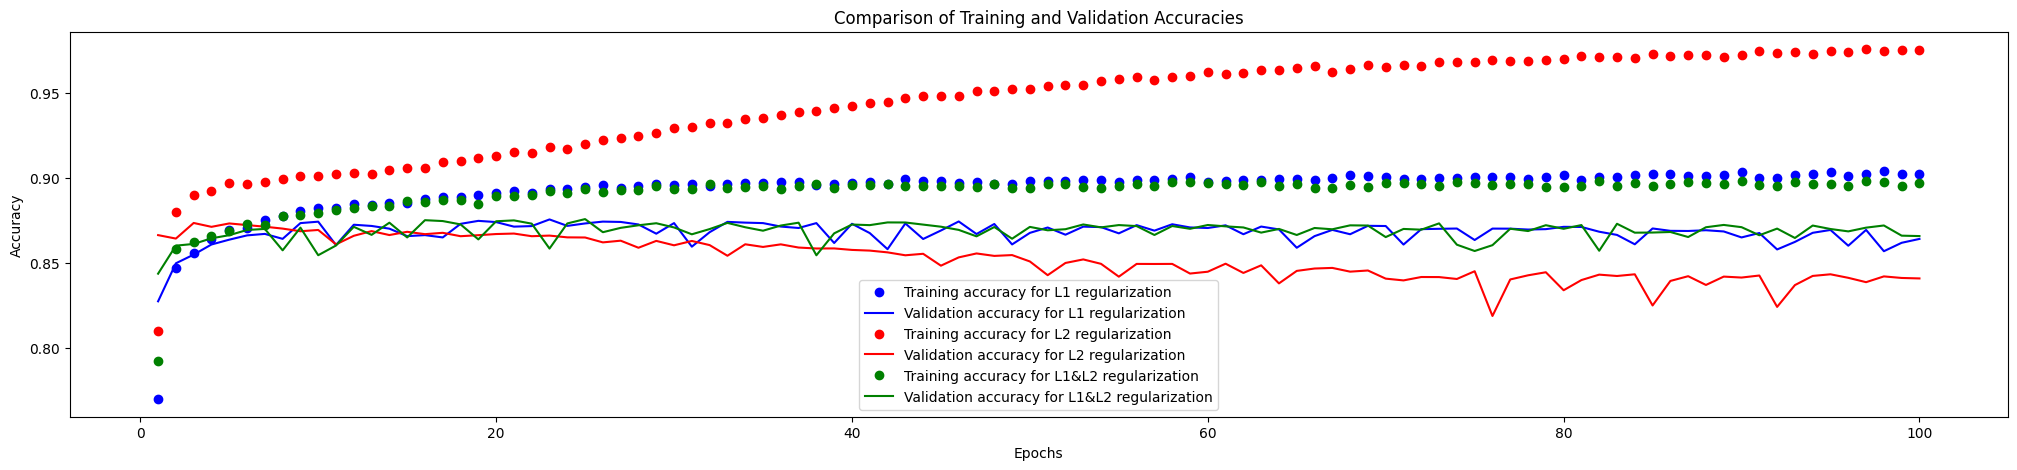

In [26]:
# Compare the accuracies of three training processes
acc1 = historyL1.history['acc']
val_acc1 = historyL1.history['val_acc']
acc2 = historyL2.history['acc']
val_acc2 = historyL2.history['val_acc']
acc3 = historyL3.history['acc']
val_acc3 = historyL3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, 'L1 regularization', 'L2 regularization', 'L1&L2 regularization')

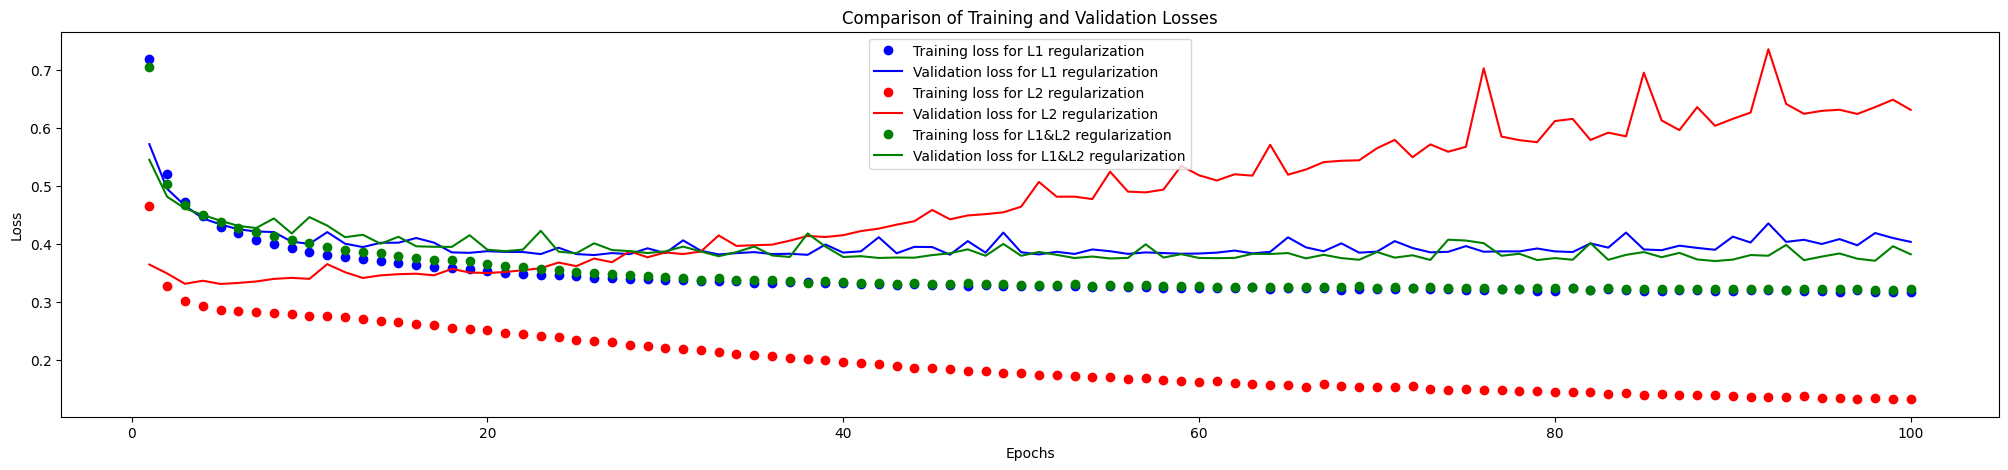

In [27]:
# Compare the losses of three training processes
loss1 = historyL1.history['loss']
val_loss1 = historyL1.history['val_loss']
loss2 = historyL2.history['loss']
val_loss2 = historyL2.history['val_loss']
loss3 = historyL3.history['loss']
val_loss3 = historyL3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, 'L1 regularization', 'L2 regularization', 'L1&L2 regularization')

Porównanie strat dla regularyzacji L1, L2 oraz L1&L2 pokazuje nam, że najmniejszą stratę podczas uczenia uzyskano dla regularyzacji L2, ale jednocześnie największą stratę dla danych walidacyjnych. Nie ma dużej różnicy między stosowaniem regularyzacji L1 i L1&L2, które osiągnęły mniejszą wariancję niż L2.

Mogliśmy zobaczyć, jak kara za regularyzację L2 (`l2(0.001)`) wpłynęła na proces uczenia. `l2(0.001)` oznacza, że każdy współczynnik w macierzy wag warstwy doda `0.001 * weight_coefficient_value` do całkowitej utraty sieci. Zauważ, że ponieważ ta kara jest _dodawana tylko w czasie treningu_, strata dla tej sieci była znacznie większa podczas treningu
niż w czasie testu.

In [28]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8755199909210205 , achieved in the  22 epoch.
Max accuracy for model 2 is:  0.8734400272369385 , achieved in the  2 epoch.
Max accuracy for model 3 is:  0.8757200241088867 , achieved in the  24 epoch.


## Walka z nadmiernym dopasowaniem: dodawanie opuszczania (dropout)

<b>Dropout</b> to jedna z najskuteczniejszych i najczęściej używanych technik regularyzacji sieci neuronowych, opracowana przez Hintona i jego studentów z University of Toronto. Dropout zastosowany do warstwy polega na losowym „wypadnięciu” (dropout) (tj. ustawieniu na zero) pewnej liczby cech wyjściowych warstwy podczas uczenia z określonym prawdopodobieństwem (zwykle między 0,2 a 0,5). W czasie testu żadne jednostki nie są odrzucane, a zamiast tego wartości wyjściowe warstwy są zmniejszane o współczynnik równy wskaźnikowi porzucania, aby zrównoważyć fakt, że więcej jednostek jest aktywnych niż w czasie szkolenia.

Aby to zilustrować, rozważmy macierz Numpy zawierającą dane wyjściowe warstwy `layer_output` o kształcie `(batch_size, features)`. W czasie treningu zerowalibyśmy losowo ułamek wartości w macierzy i skalowalibyśmy o 0,5, aby zachować spójność z podobną siłą stymulacji w czasie testu i pozostawić niezmienioną moc wyjściową w czasie testu:

In [29]:
# At training time:
#layer_output *= np.randint(0, high=2, size=layer_output.shape)
# We are scaling *up* to stay consistent with the stimulations in the test time
#layer_output /= 0.5

Ta technika może wydawać się dziwna i arbitralna. Dlaczego miałoby to pomóc w zmniejszeniu nadmiernego dopasowania? Geoff Hinton powiedział, że zainspirował go między innymi mechanizm zapobiegania oszustwom stosowany przez banki – jak sam mówi: _„Poszedłem do swojego banku. Kasjerzy ciągle się zmieniali i zapytałem jednego z nich dlaczego. Nie wiedziałem, ale często się przemieszczali. Pomyślałem, że tak musi być, ponieważ skuteczne oszukanie banku wymagałoby współpracy między pracownikami. To uświadomiło mi, że losowe usuwanie różnych podzbiorów neuronów na każdym przykładzie zapobiegłoby spiskom, a tym samym zmniejszyć przeuczenie"_.

Podstawową ideą jest to, że wprowadzenie szumu do wartości wyjściowych warstwy może rozbić wzorce zdarzeń, które nie są znaczące (co Hinton nazywa „spiskami”), które sieć zaczęłaby zapamiętywać, gdyby nie było szumu.

W Keras możesz wprowadzić dropout w sieci poprzez warstwę `Dropout`, która jest nakładana na wyjście warstwy tuż przed nią.

In [30]:
#model.add(layers.Dropout(0.5))

Z dropoutem należy korzystać ostrożnie, zwłaszcza w przypadku warstw zawierających niewielką liczbę jednostek, ponieważ zamiana zbyt wielu jednostek może skutkować niedopasowaniem, dlatego w kolejnych eksperymentach podwajamy liczbę jednostek w warstwach ukrytych.

Przeprowadźmy trzy eksperymenty z odrzucaniem różnych prawdopodobieństw `probdrop`, aby sprawdzić, który z nich najbardziej zmniejsza przeuczenie w naszej sieci IMDB:

In [31]:
def Create3LModelL1Dropout(num_top_words, hl1 = 8, hl2 = 4, probdrop=0.5):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dropout(probdrop))
    model.add(layers.Dense(hl2, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu'))
    model.add(layers.Dropout(probdrop))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [32]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, hl2 = 8, probdrop=0.5)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyD1 = model1.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - acc: 0.5649 - loss: 1.1636 - val_acc: 0.8287 - val_loss: 0.6374
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7246 - loss: 0.6713 - val_acc: 0.8479 - val_loss: 0.5460
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.7746 - loss: 0.6120 - val_acc: 0.8522 - val_loss: 0.5244
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.7964 - loss: 0.5809 - val_acc: 0.8523 - val_loss: 0.4935
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8054 - loss: 0.5696 - val_acc: 0.8598 - val_loss: 0.4729
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8078 - loss: 0.5536 - val_acc: 0.8616 - val_loss: 0.4730
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8107 - loss: 0.5493 - val_acc: 0.8659 - val_loss: 0.4727
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8176 - loss: 0.5438 - val_acc: 0.8655 - val_loss: 0.4690
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8

In [33]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, hl2 = 8, probdrop=0.25)

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyD2 = model2.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - acc: 0.6556 - loss: 1.1342 - val_acc: 0.8498 - val_loss: 0.5715
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8261 - loss: 0.5879 - val_acc: 0.8480 - val_loss: 0.5279
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8443 - loss: 0.5378 - val_acc: 0.8642 - val_loss: 0.4828
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8523 - loss: 0.5189 - val_acc: 0.8586 - val_loss: 0.4858
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8532 - loss: 0.5038 - val_acc: 0.8512 - val_loss: 0.4935
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8579 - loss: 0.4964 - val_acc: 0.8588 - val_loss: 0.4745
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8572 - loss: 0.4851 - val_acc: 0.8697 - val_loss: 0.4589
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8607 - loss: 0.4847 - val_acc: 0.8698 - val_loss: 0.4482
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8

In [34]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, hl2 = 8, probdrop=0.15)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

historyD3 = model3.fit(x_train, y_train,
                       epochs=100,
                       batch_size=256,
                       validation_data=(x_val, y_val))

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - acc: 0.6831 - loss: 1.1049 - val_acc: 0.8366 - val_loss: 0.6016
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8276 - loss: 0.5878 - val_acc: 0.8614 - val_loss: 0.5027
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.8437 - loss: 0.5309 - val_acc: 0.8629 - val_loss: 0.4868
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.8579 - loss: 0.4982 - val_acc: 0.8647 - val_loss: 0.4730
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8573 - loss: 0.4906 - val_acc: 0.8670 - val_loss: 0.4625
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8583 - loss: 0.4825 - val_acc: 0.8605 - val_loss: 0.4705
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8678 - loss: 0.4622 - val_acc: 0.8723 - val_loss: 0.4447
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.8699 - loss: 0.4564 - val_acc: 0.8596 - val_loss: 0.4648
Epoch 9/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.8

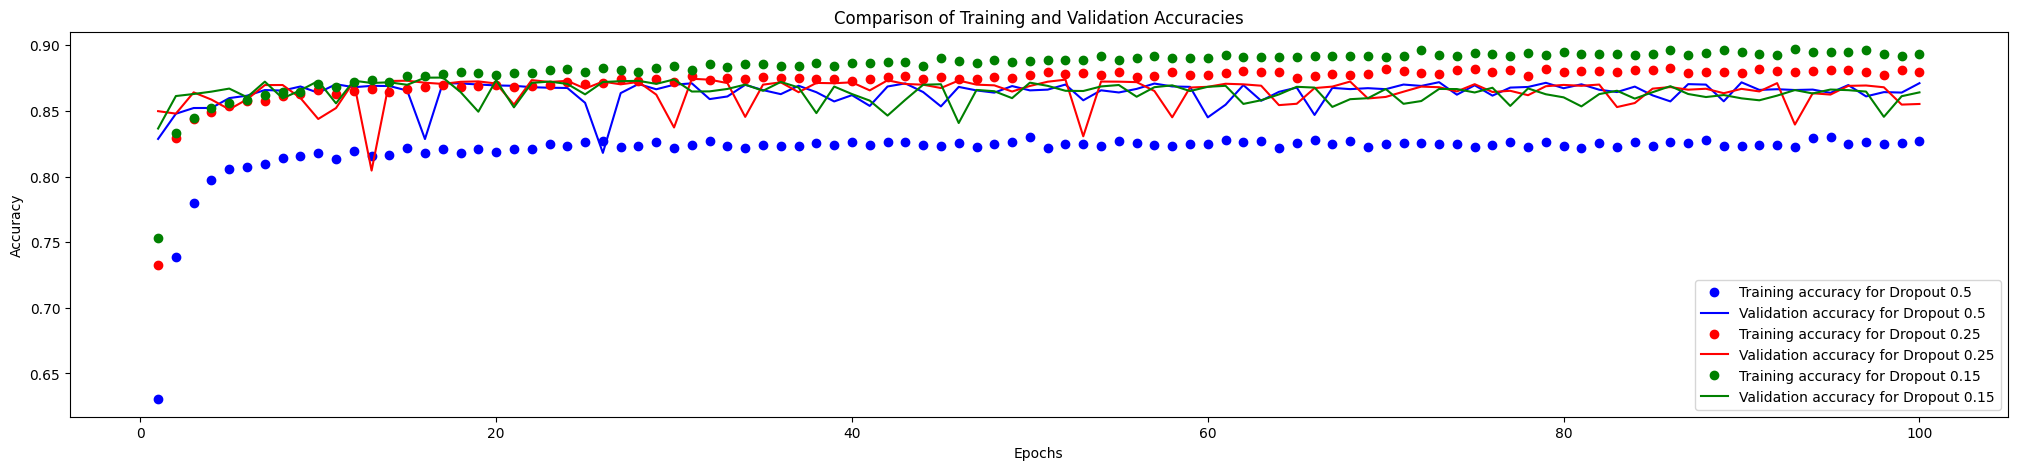

In [35]:
# Compare the accuracies of three training processes
acc1 = historyD1.history['acc']
val_acc1 = historyD1.history['val_acc']
acc2 = historyD2.history['acc']
val_acc2 = historyD2.history['val_acc']
acc3 = historyD3.history['acc']
val_acc3 = historyD3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, 'Dropout 0.5', 'Dropout 0.25', 'Dropout 0.15')

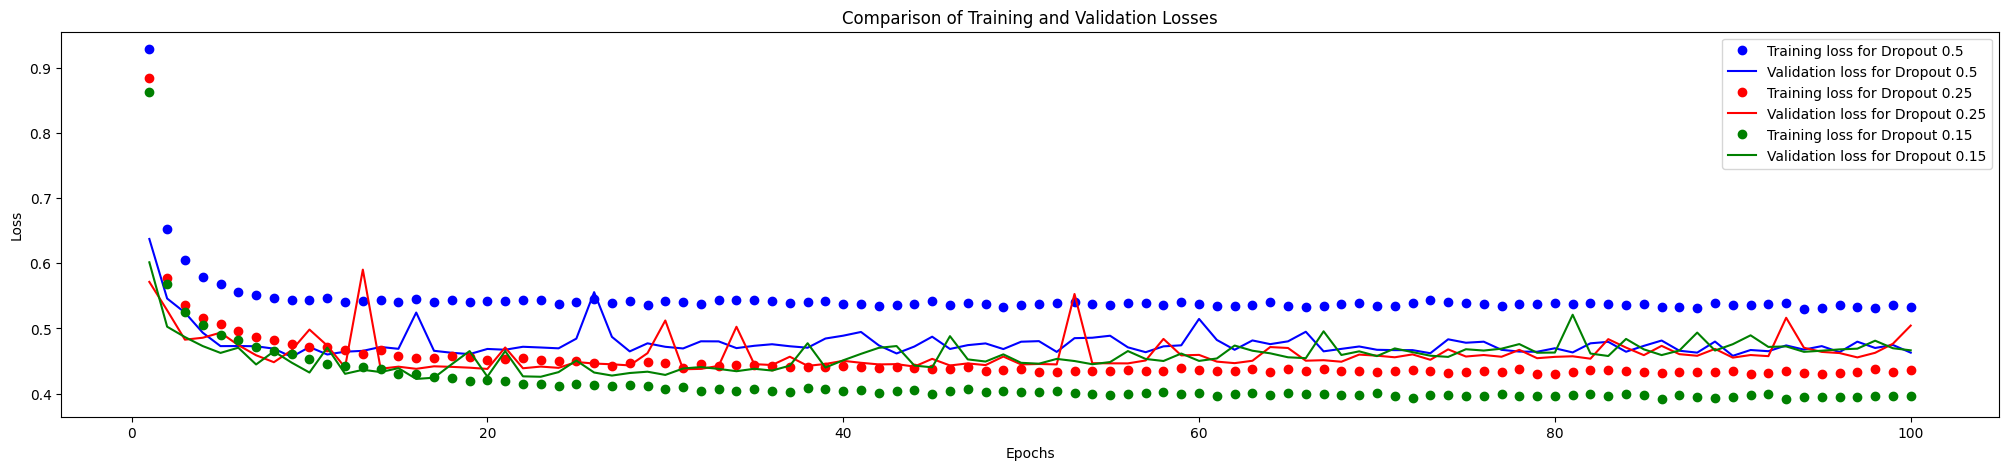

In [36]:
# Compare the losses of three training processes
loss1 = historyD1.history['loss']
val_loss1 = historyD1.history['val_loss']
loss2 = historyD2.history['loss']
val_loss2 = historyD2.history['val_loss']
loss3 = historyD3.history['loss']
val_loss3 = historyD3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, 'Dropout 0.5', 'Dropout 0.25', 'Dropout 0.15')

Nie ma dużej różnicy w dokładności walidacji ani stratach tych modeli; jednak bardziej stabilny jest model z najmniejszym odrzuceniem (dropout).

In [37]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8719199895858765 , achieved in the  72 epoch.
Max accuracy for model 2 is:  0.8745200037956238 , achieved in the  30 epoch.
Max accuracy for model 3 is:  0.8754400014877319 , achieved in the  16 epoch.


## Streszczenie

Podsumowując: oto najczęstsze sposoby zapobiegania nadmiernemu dopasowaniu w sieciach neuronowych:
* Uzyskanie większej ilości danych treningowych.
* Zmniejszenie pojemności (parametrów) sieci.
* Dodanie regularyzacji wag.
* Dodanie rezygnacji/odrzucania (dropout).

Teraz zmień niektóre hiperparametry (zielony i czerwony) w powyższych modelach i spróbuj uzyskać ostateczny model, który będzie jeszcze lepszy niż powyższy.

In [38]:
def Create2LModelL1Dropout(num_top_words, hl1 = 32, probdrop=0.2):
    model = models.Sequential()
    model.add(layers.Dense(hl1, kernel_regularizer=regularizers.l1(0.001),
                           activation='relu', input_shape=(num_top_words,)))
    model.add(layers.Dropout(probdrop))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [39]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model1 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 8, probdrop=0.2)

model1.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history1 = model1.fit(x_train, y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - acc: 0.6014 - loss: 0.9598 - val_acc: 0.8130 - val_loss: 0.6377
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.7283 - loss: 0.6430 - val_acc: 0.8498 - val_loss: 0.5531
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.7552 - loss: 0.5845 - val_acc: 0.8557 - val_loss: 0.5143
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.7870 - loss: 0.5506 - val_acc: 0.8595 - val_loss: 0.4827
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8069 - loss: 0.5297 - val_acc: 0.8612 - val_loss: 0.4659
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8143 - loss: 0.5172 - val_acc: 0.8548 - val_loss: 0.4637
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8206 - loss: 0.5116 - val_acc: 0.8659 - val_loss: 0.4477
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8193 - loss: 0.5037 - val_acc: 0.8608 - val_loss: 0.4448
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - ac

In [40]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model2 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 16, probdrop=0.2)

model2.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history2 = model2.fit(x_train, y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - acc: 0.6345 - loss: 1.1997 - val_acc: 0.8139 - val_loss: 0.6412
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.7726 - loss: 0.6395 - val_acc: 0.8330 - val_loss: 0.5534
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8048 - loss: 0.5755 - val_acc: 0.8576 - val_loss: 0.5081
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8165 - loss: 0.5447 - val_acc: 0.8604 - val_loss: 0.4829
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8233 - loss: 0.5277 - val_acc: 0.8615 - val_loss: 0.4715
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.8237 - loss: 0.5210 - val_acc: 0.8524 - val_loss: 0.4793
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8336 - loss: 0.5048 - val_acc: 0.8648 - val_loss: 0.4532
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8363 - loss: 0.4952 - val_acc: 0.8449 - val_loss: 0.4761
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc

In [41]:
# Load IMDB data with the specified number of the most frequently words
num_top_words=2000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_top_words)

x_train, y_train  = vectorize_data_float_labels(train_data, train_labels, num_top_words)
x_val, y_val = vectorize_data_float_labels(test_data, test_labels, num_top_words)

model3 = Create3LModelL1Dropout(num_top_words=num_top_words, hl1 = 32, probdrop=0.2)

model3.compile(optimizer='rmsprop',
               loss='binary_crossentropy',
               metrics=['acc'])

history3 = model3.fit(x_train, y_train,
                      epochs=100,
                      batch_size=512,
                      validation_data=(x_val, y_val))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - acc: 0.6112 - loss: 1.7314 - val_acc: 0.7822 - val_loss: 0.7520
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.7720 - loss: 0.6972 - val_acc: 0.8051 - val_loss: 0.6187
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.7959 - loss: 0.6267 - val_acc: 0.7968 - val_loss: 0.6210
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8113 - loss: 0.5975 - val_acc: 0.8449 - val_loss: 0.5463
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8255 - loss: 0.5709 - val_acc: 0.8424 - val_loss: 0.5381
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - acc: 0.8310 - loss: 0.5617 - val_acc: 0.8551 - val_loss: 0.5048
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8328 - loss: 0.5543 - val_acc: 0.8512 - val_loss: 0.5106
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.8379 - loss: 0.5417 - val_acc: 0.8524 - val_loss: 0.5051
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - a

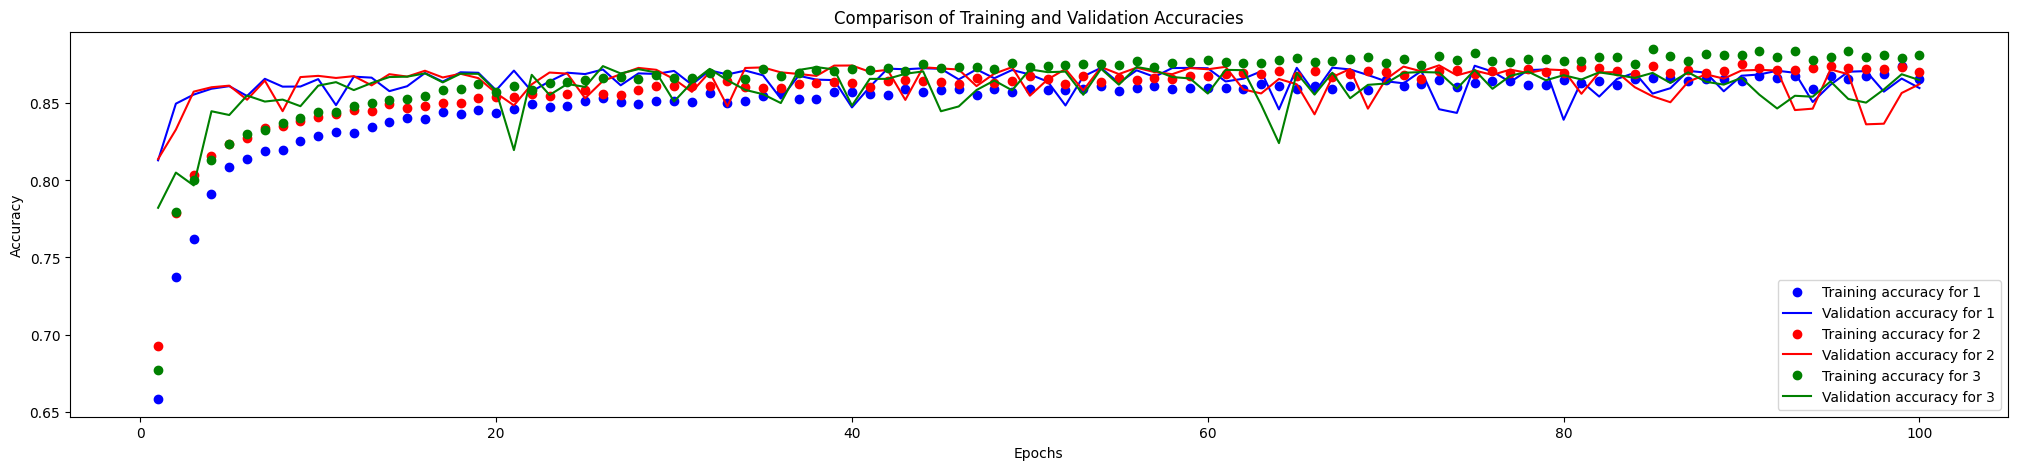

In [42]:
# Compare the accuracies of three training processes
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']

PlotThreeAccuracyComparison(acc1, val_acc1, acc2, val_acc2, acc3, val_acc3, '1', '2', '3')

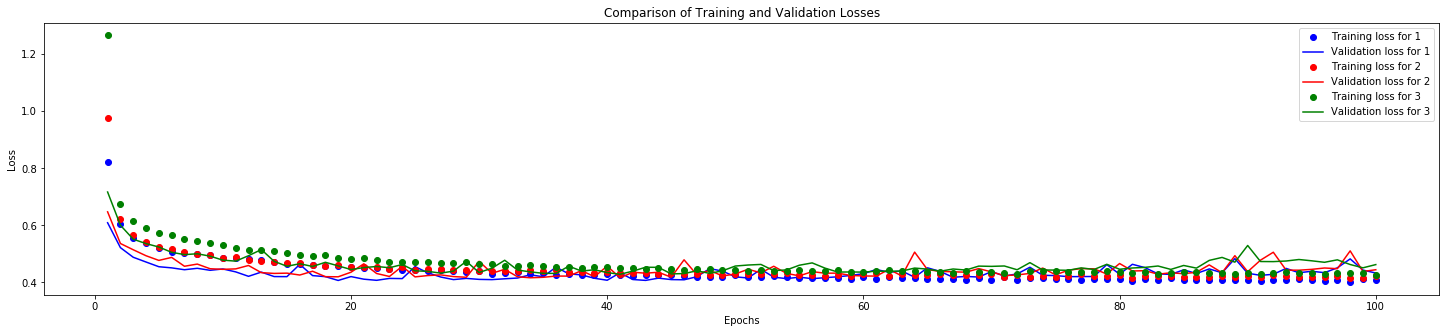

In [46]:
# Compare the losses of three training processes
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotThreeLossComparison(loss1, val_loss1, loss2, val_loss2, loss3, val_loss3, '1', '2', '3')

In [47]:
argmax1 = np.argmax(val_acc1)
argmax2 = np.argmax(val_acc2)
argmax3 = np.argmax(val_acc3)
print ('Max accuracy for model 1 is: ', val_acc1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
print ('Max accuracy for model 2 is: ', val_acc2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
print ('Max accuracy for model 3 is: ', val_acc3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

Max accuracy for model 1 is:  0.8764399886131287 , achieved in the  45 epoch.
Max accuracy for model 2 is:  0.8758800029754639 , achieved in the  40 epoch.
Max accuracy for model 3 is:  0.8751999735832214 , achieved in the  40 epoch.


Jak widać, udało się pozbyć wariancji modelu, gdyż wykresy kropkowane (dla danych uczących) prawie pokryły się z wykresami kreskowanymi (dla danych walidacyjnych).

## Zadanie:

Proszę spróbować przeprowadzić taki proces regularyzacji modeli dla innego, nietrywialnego zbioru uczącego.

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('web-page-phishing.csv')

In [48]:
#checking the data

df.isna().sum()

url_length        0
n_dots            0
n_hypens          0
n_underline       0
n_slash           0
n_questionmark    0
n_equal           0
n_at              0
n_and             0
n_exclamation     0
n_space           0
n_tilde           0
n_comma           0
n_plus            0
n_asterisk        0
n_hastag          0
n_dollar          0
n_percent         0
n_redirection     0
phishing          0
dtype: int64

In [51]:
data = df.drop('phishing', axis=1)
labels = df['phishing']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

In [ ]:
def create_2layer_model(n1 = 16, n2 = 8):
    model = models.Sequential()
    model.add(layers.Dense(n1, activation='relu', input_shape=df.shape[1]))
    model.add(layers.Dense(n2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
model_1 = create_2layer_model(32, 16)

model_1.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
                
model_1.fit